In [3]:
import argparse
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

import torch.nn.functional as F
import matplotlib.pyplot as plt

# Change the working directory to the parent directory so imports and everything else works
import os
os.chdir("..")

import data_loader.data_loaders as module_data
import model.model as module_arch
from utils.parse_config import ConfigParser
from utils import to, PLYSaver, DS_Wrapper



In [29]:
# Sequence: 01 in configs for custom data, 07 for KITTI data
# config_path="/usr/stud/kaa/thesis/MonoRec/configs/test/pointcloud_monorec_deepscenario_kitti.json"
config_path="/usr/stud/kaa/thesis/MonoRec/configs/test/pointcloud_monorec_deepscenario.json"

# True is good for data exploration, False is good for point cloud & backprojection
shuffle_batches=True

def custom_argparse():
    """Hacky solution to allow for custom command line arguments in a
    Notebook instead of a command-line interface.

    The config is just given as the default argument."""
    parser = argparse.ArgumentParser(description='PyTorch Template')

    parser.add_argument('-r', '--resume', default=None, type=str,
                    help='path to latest checkpoint (default: None)')
    parser.add_argument('-c', '--config', default=config_path, type=str,
                    help='config file path (default: None)')
    parser.add_argument('-d', '--device', default=None, type=str,
                    help='indices of GPUs to enable (default: all)')

    return ConfigParser(parser)


config = custom_argparse()

In [30]:
logger = config.get_logger('test')

output_dir = Path(config.config.get("output_dir", "saved"))
output_dir.mkdir(exist_ok=True, parents=True)
file_name = config.config.get("file_name", "pc.ply")
use_mask = config.config.get("use_mask", True)
roi = config.config.get("roi", None)

max_d = config.config.get("max_d", 30)
min_d = config.config.get("min_d", 3)

start = config.config.get("start", 0)
end = config.config.get("end", -1)

# setup data_loader instances
data_loader = DataLoader(DS_Wrapper(config.initialize('data_set', module_data), start=start, end=end), batch_size=1, shuffle=shuffle_batches, num_workers=8)

# build model architecture
model = config.initialize('arch', module_arch)
logger.info(model)

if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

mask_fill = 32

n = data_loader.batch_size

target_image_size = data_loader.dataset.dataset.target_image_size

plysaver = PLYSaver(target_image_size[0], target_image_size[1], min_d=min_d, max_d=max_d, batch_size=n, roi=roi, dropout=.75)
plysaver.to(device)

pose_buffer = []
intrinsics_buffer = []
mask_buffer = []
keyframe_buffer = []
depth_buffer = []

buffer_length = 5
min_hits = 1
key_index = buffer_length // 2


/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/stud/kaa/miniconda3/envs/monorec/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MonoRecModel(
  (_feature_extractor): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [31]:
def show_images(data, output):
    """Function to display images sampled from the dataloader and depth predictions of MonoRec side by side"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and a set of subplots

    # Display the image from the dataloader
    image1 = data["keyframe"].squeeze().cpu().permute(1,2,0)
    image1 = (image1 + 0.5) * 255 # undo the transformation preprocess_image() from dataset class does
    image1 = image1.numpy().astype(np.uint8) # convert to numpy and then to integer values
    axs[0].imshow(image1)
    axs[0].set_title('Image from dataloader')

    # Display the depth predictions of MonoRec
    image2 = output.squeeze().cpu()
    axs[1].imshow(image2)
    axs[1].set_title('Inverse depth predictions of MonoRec')

    # Display the mas prediction of MonoRec
    image3 = data["cv_mask"].squeeze().cpu()
    axs[2].imshow(image3)
    axs[2].set_title("Mask prediction of MonoRec")

    plt.show()

Getting the data from the dataloader, run this cell to get the iterator object from scratch

In [32]:
with torch.no_grad():
    data_loader_iter = data_loader.__iter__()

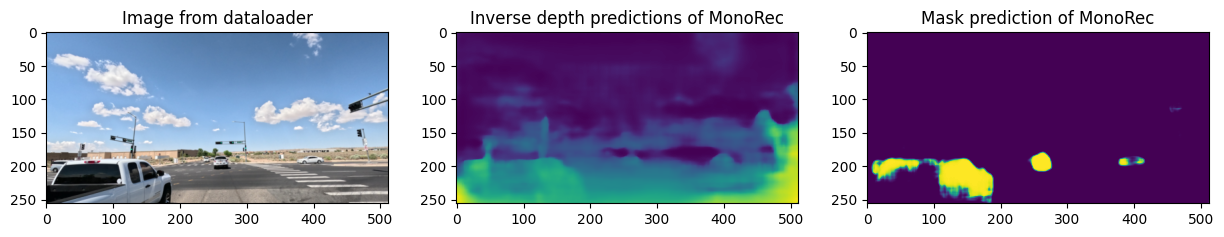

In [34]:
with torch.no_grad():
        data, target = data_loader_iter.__next__()
        data = to(data, device) # using custom util function

        # The target is the depth we use as the labels, when creating a pointcloud
        # it is NOT used
        result = model(data)
        if not isinstance(result, dict):
                result = {"result": result[0]}
        output = result["result"]

show_images(data, output)

### Exploration

In [ ]:
print("Keys of the data object (input): ", data.keys())
print("Keyframe shape: ",data["keyframe"].shape)
print("Ouput depth map shape: ", output.shape)

Keys of the data object (input):  dict_keys(['keyframe', 'keyframe_pose', 'keyframe_intrinsics', 'frames', 'poses', 'intrinsics', 'sequence', 'image_id', 'inv_depth_min', 'inv_depth_max', 'cv_depth_steps', 'cost_volume', 'single_frame_cvs', 'cv_module_time', 'image_features', 'cv_mask', 'predicted_inverse_depths', 'result', 'mask'])
Keyframe shape:  torch.Size([1, 3, 256, 512])
Ouput depth map shape:  torch.Size([1, 1, 256, 512])


In [ ]:
print(data["poses"])
print(data["cv_mask"].shape)

[tensor([[[ 9.9994e-01,  5.7202e-03, -9.7289e-03,  2.4930e+00],
         [-5.7505e-03,  9.9998e-01, -3.0873e-03,  7.2545e+00],
         [ 9.7110e-03,  3.1430e-03,  9.9995e-01,  3.7509e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0'), tensor([[[ 9.9994e-01,  5.2704e-03, -1.0073e-02,  2.5105e+00],
         [-5.2945e-03,  9.9998e-01, -2.3634e-03,  7.3098e+00],
         [ 1.0060e-02,  2.4165e-03,  9.9995e-01,  3.7862e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')]
torch.Size([1, 1, 256, 512])


In [ ]:
data["keyframe_pose"]

In [ ]:
data["image_id"]

In [10]:
data["keyframe"]

tensor([[[[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          ...,
          [-0.3902, -0.3941, -0.3863,  ..., -0.4412, -0.4412, -0.4451],
          [-0.3863, -0.3941, -0.3902,  ..., -0.4412, -0.4451, -0.4373],
          [-0.3863, -0.4020, -0.4059,  ..., -0.4451, -0.4412, -0.4412]],

         [[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          ...,
          [-0.3784, -0.3824, -0.3863,  ..., -0.4294, -0.4294, -0.4373],
          [-0.3745, -0.3784, -0.3784,  ..., -0.4373, -0.4333, -0.4333],
          [-0.3824, -0.3863, -0.3824,  ..., -0.4333, -0.4373, -0.4294]],

         [[ 0.5000,  0.5000,  0.5000,  ...,  0.5000,  0.5000,  0.5000],
          [ 0.5000,  0.5000,  

## Trajectory Visualization

In [ ]:
def read_kitti_trajectory_from_line(line):
    """Helper function to read in the x-y-z transformations from the
    given line of the saved format"""
    cols = line.split(" ")
    x = float(cols[3])
    y = float(cols[7])
    z = float(cols[11])

    return x,y,z

def read_kitti_orientation_from_line(line):
    """Helper function to read in the rotation matrix
    from the saved trajectory"""
    cols = line.split(" ")
    R = np.zeros((3,3))

    R[0,0] = float(cols[0])
    R[0,1] = float(cols[1])
    R[0,2] = float(cols[2])

    R[1,0] = float(cols[4])
    R[1,1] = float(cols[5])
    R[1,2] = float(cols[6])

    R[2,0] = float(cols[8])
    R[2,1] = float(cols[9])
    R[2,2] = float(cols[10])

    return R


def read_kitti_pose_from_line(line):
    T_w_cam0 = np.fromstring(line, dtype=float, sep=' ')
    T_w_cam0 = T_w_cam0.reshape(3, 4)
    T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))

    return T_w_cam0

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_trajectory(x, y, z, orientations, every_nth=50):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot trajectory
    ax.plot(x, y, z, 'k-', label='Trajectory', linewidth=2.0)

    # Set maximum and minimum values for all axes to be the maximum absolute
    # value
    x_abs = [abs(num) for num in x]
    y_abs = [abs(num) for num in y]
    z_abs = [abs(num) for num in z]

    max_value = max(max(x_abs), max(y_abs), max(z_abs))
    min_value = -max_value

    ax.set_xlim([min_value, max_value])
    ax.set_ylim([min_value, max_value])
    ax.set_zlim([min_value, max_value])

    # Scale factor for the coordinate frame axes
    coordinate_scale = max_value * 0.1

    # Plot camera orientations
    for i in range(len(x)):
        R = orientations[i]
        origin = np.array([x[i], y[i], z[i]])
        x_axis = R @ (coordinate_scale * np.array([1,0,0]).reshape(3,1))
        y_axis = R @ (coordinate_scale * np.array([0,1,0]).reshape(3,1))
        z_axis = R @ (coordinate_scale * np.array([0,0,1]).reshape(3,1))

        if i == 0:
            # Plot the camera center
            ax.scatter(x[i], y[i], z[i], color='k')
            ax.quiver(origin[0], origin[1], origin[2], x_axis[0], x_axis[1], x_axis[2], color='r', label='Camera X-axis', arrow_length_ratio=0.1)
            ax.quiver(origin[0], origin[1], origin[2], y_axis[0], y_axis[1], y_axis[2], color='g', label='Camera Y-axis', arrow_length_ratio=0.1)
            ax.quiver(origin[0], origin[1], origin[2], z_axis[0], z_axis[1], z_axis[2], color='b', label='Camera Z-axis', arrow_length_ratio=0.1)
        elif i % every_nth == 0:
            # Plot the camera center
            ax.scatter(x[i], y[i], z[i], color='k')
            ax.quiver(origin[0], origin[1], origin[2], x_axis[0], x_axis[1], x_axis[2], color='r', arrow_length_ratio=0.1)
            ax.quiver(origin[0], origin[1], origin[2], y_axis[0], y_axis[1], y_axis[2], color='g', arrow_length_ratio=0.1)
            ax.quiver(origin[0], origin[1], origin[2], z_axis[0], z_axis[1], z_axis[2], color='b', arrow_length_ratio=0.1)


    # Axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y (up/down)')
    ax.set_zlabel('Z (forward)')

    ax.legend()

    plt.show()


In [ ]:
# trajectory_path = "/usr/stud/kaa/thesis/MonoRec/example/data/kitti/poses/07.txt"
trajectory_path = "/usr/stud/kaa/thesis/data_temp/deep_scenario/monorec/poses_dvso/01.txt"

x = []
y = []
z = []
R = []
with open(trajectory_path, "r") as file:
    lines = file.readlines()

for line in lines:
    # Currently read-in coordinates x,y,z and rotation matrix R_w_cam0
    x_curr, y_curr, z_curr = read_kitti_trajectory_from_line(line)
    R_curr = read_kitti_orientation_from_line(line)

    x.append(x_curr)
    y.append(y_curr)
    z.append(z_curr)
    R.append(R_curr)

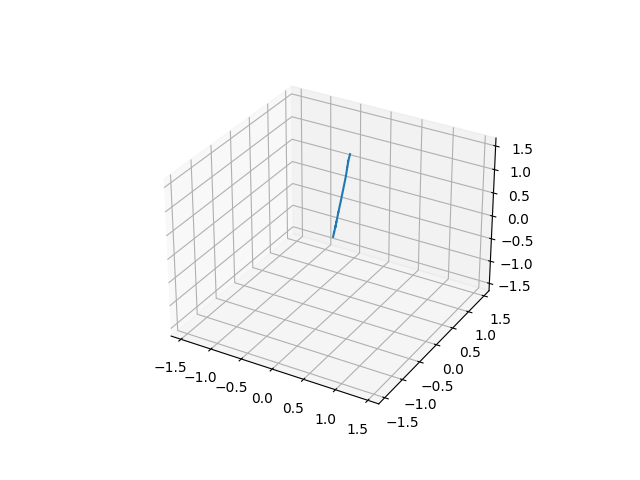

In [ ]:
FANCY_PLOT = True

if FANCY_PLOT:
    visualize_trajectory(x,y,z,R)
else:
    # Create a new figure and add a 3D subplot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory
    ax.plot(x, y, z)

    # Set maximum and minimum values for all axes to be the maximum absolute
    # value
    x_abs = [abs(num) for num in x]
    y_abs = [abs(num) for num in y]
    z_abs = [abs(num) for num in z]

    max_value = max(max(x_abs), max(y_abs), max(z_abs))
    min_value = -max_value

    ax.set_xlim([min_value, max_value])
    ax.set_ylim([min_value, max_value])
    ax.set_zlim([min_value, max_value])

    # Display the plot
    plt.show()



In [ ]:
print("Double checking if translation and orientation are read correctly by comparing it to pose:")
print(line)
print(read_kitti_trajectory_from_line(line))
print(read_kitti_orientation_from_line(line))

print(read_kitti_pose_from_line(line))

Double checking if translation and orientation are read correctly by comparing it to pose:
0.999573827 0.022237552 0.018911537 0.093197890 -0.022202194 0.999751329 -0.002077549 0.309177846 -0.018953035 0.001656786 0.999818981 1.599525571

(0.09319789, 0.309177846, 1.599525571)
[[ 0.99957383  0.02223755  0.01891154]
 [-0.02220219  0.99975133 -0.00207755]
 [-0.01895304  0.00165679  0.99981898]]
[[ 0.99957383  0.02223755  0.01891154  0.09319789]
 [-0.02220219  0.99975133 -0.00207755  0.30917785]
 [-0.01895304  0.00165679  0.99981898  1.59952557]
 [ 0.          0.          0.          1.        ]]


In [ ]:
print("Total number of trajectory points: ", len(x))
print("Maximum value: ", max(max(x), max(y), max(z)))
print("Minimum value: ", min(min(x), min(y), min(z)))
for row, (x_plot, y_plot, z_plot) in enumerate(zip(x,y,z)):
    print(f"x: {x_plot}, y: {y_plot}, z: {z_plot}")
    if row > 20: break


Total number of trajectory points:  718
Maximum value:  1.599525571
Minimum value:  0.000822303
x: 0.000822303, y: 0.002241754, z: 0.011614536
x: 0.001276278, y: 0.003402896, z: 0.017337658
x: 0.006056496, y: 0.018472938, z: 0.097632863
x: 0.002046732, y: 0.005653317, z: 0.028578104
x: 0.004126249, y: 0.009509031, z: 0.052155003
x: 0.002861263, y: 0.007885283, z: 0.039811905
x: 0.003439471, y: 0.009078421, z: 0.045499116
x: 0.003671347, y: 0.01016053, z: 0.050991591
x: 0.004155495, y: 0.01127593, z: 0.056588393
x: 0.004482199, y: 0.012455002, z: 0.062120371
x: 0.004891957, y: 0.013573848, z: 0.067723699
x: 0.005368179, y: 0.014662787, z: 0.073202476
x: 0.0057776, y: 0.015746338, z: 0.078743368
x: 0.006215962, y: 0.016766286, z: 0.084205024
x: 0.007991438, y: 0.020324199, z: 0.103818297
x: 0.007013218, y: 0.01896595, z: 0.095209479
x: 0.009104658, y: 0.022571059, z: 0.114877924
x: 0.007799173, y: 0.021043545, z: 0.105972178
x: 0.009072919, y: 0.024705028, z: 0.125670761
x: 0.008539914, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_fulcrum(origin, orientation):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the fulcrum
    ax.scatter(*origin, color='r')
    print("origin")
    print(*origin)

    # Plot the x, y, z axes
    for i, color in zip(range(3), ['r', 'g', 'b']):
        axis = np.array([0, 0, 0])
        axis[i] = 10
        # Rotate the axis according to the orientation of the camera
        axis = np.dot(orientation, axis)
        ax.quiver(*origin, *axis, color=color)
        print("axis")
        print(*axis)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Example usage:
origin = np.array([0, 0, 0])
orientation = np.eye(3)  # Identity matrix, camera is aligned with world axes
plot_camera_fulcrum(origin, orientation)